In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.scrna_dataset as scrna_dataset
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18]
# branch_defs = [((0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18), 0.40540540540540543, 1), ((0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16), 0.3733733733733734, 0.40540540540540543), ((0, 2, 3, 4, 5, 6, 8, 9, 10, 14, 15, 16), 0.3663663663663664, 0.3733733733733734), ((0, 2, 3, 4, 5, 6, 8, 10, 14, 15), 0.34734734734734735, 0.3663663663663664), ((0, 2, 3, 4, 5, 6, 8, 10, 14), 0.33733733733733734, 0.34734734734734735), ((0, 2, 3, 4, 5, 6, 8, 10), 0.3313313313313313, 0.33733733733733734), ((9, 16), 0.3033033033033033, 0.3663663663663664), ((0, 2, 3, 4, 5, 8, 10), 0.2962962962962963, 0.3313313313313313), ((0, 2, 4), 0.26226226226226224, 0.2962962962962963), ((2, 4), 0.20520520520520522, 0.26226226226226224), ((3, 5, 8, 10), 0.15615615615615616, 0.2962962962962963), ((3, 5, 8), 0.14114114114114115, 0.15615615615615616), ((3, 8), 0.0, 0.14114114114114115), ((18,), 0, 0.40540540540540543), ((12,), 0, 0.3733733733733734), ((15,), 0, 0.34734734734734735), ((14,), 0, 0.33733733733733734), ((6,), 0, 0.3313313313313313), ((16,), 0, 0.3033033033033033), ((9,), 0, 0.3033033033033033), ((0,), 0, 0.26226226226226224), ((2,), 0, 0.20520520520520522), ((4,), 0, 0.20520520520520522), ((10,), 0, 0.15615615615615616), ((5,), 0, 0.14114114114114115), ((8,), 0, 0.0), ((3,), 0, 0.0)]
branch_defs = [((0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18), 0, 1)]

classes = [0]
branch_defs = [((0,), 0, 1000)]

In [4]:
dataset = scrna_dataset.SingleCellDataset(
    "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_1000_uncentered.h5"
)

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

In [6]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [7]:
# Create the diffuser and model
diffuser = discrete_diffusers.GaussianDiffuser(1e-4, 1e-5, input_shape)

t_limit = 1000

model = scrna_ae.MultitaskResNet(
    len(branch_defs), input_shape[0], t_limit=t_limit, hidden_dim=16384
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/misc"
import model.train_discrete_model as train_discrete_model  # Import this AFTER setting environment

### Show the forward-diffusion process

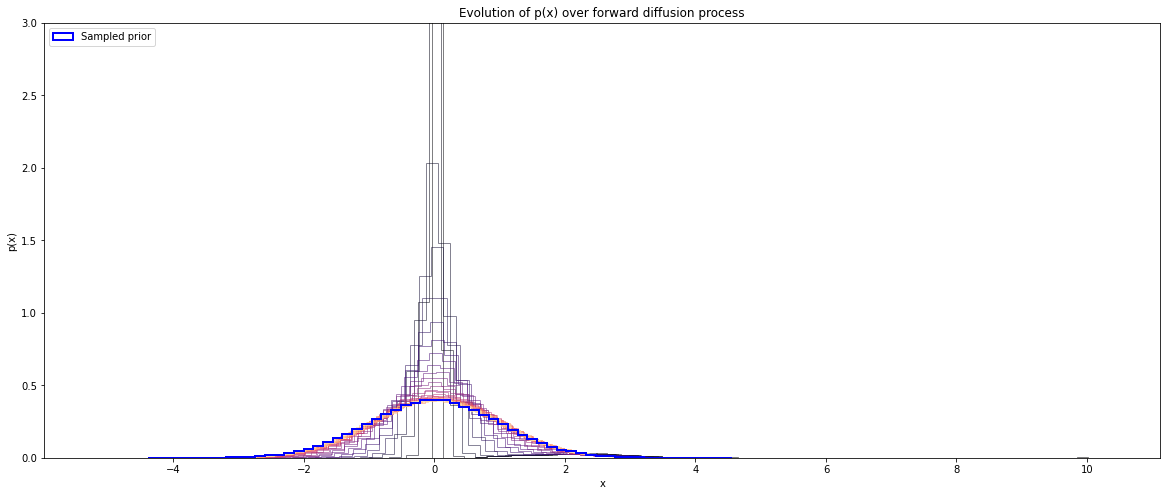

In [8]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = diffuser.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = diffuser.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward diffusion process")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [9]:
train_discrete_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "diffuser": diffuser,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 300,
        "learning_rate": 1e-3,
        "t_limit": t_limit
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "diffuser"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "3"
Loss: 1053.27: 100%|██████████████████████████████████████████| 61/61 [00:11<00:00,  5.17it/s]


Epoch 1 average Loss: 12083.49


Loss: 688.85: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.76it/s]


Epoch 2 average Loss: 820.99


Loss: 549.87: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 3 average Loss: 618.95


Loss: 457.46: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 4 average Loss: 508.00


Loss: 386.41: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 5 average Loss: 458.84


Loss: 373.90: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 6 average Loss: 407.85


Loss: 353.80: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 7 average Loss: 389.45


Loss: 333.98: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 8 average Loss: 359.53


Loss: 395.24: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 9 average Loss: 350.52


Loss: 316.71: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 10 average Loss: 330.06


Loss: 333.25: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 11 average Loss: 310.27


Loss: 290.53: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 12 average Loss: 299.62


Loss: 900.98: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 13 average Loss: 299.16


Loss: 276.94: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 14 average Loss: 289.19


Loss: 238.92: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 15 average Loss: 272.75


Loss: 274.49: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 16 average Loss: 267.83


Loss: 266.81: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 17 average Loss: 260.67


Loss: 290.98: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 18 average Loss: 260.93


Loss: 238.52: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 19 average Loss: 251.28


Loss: 220.97: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 20 average Loss: 246.29


Loss: 214.42: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 21 average Loss: 240.84


Loss: 245.19: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 22 average Loss: 231.91


Loss: 249.81: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 23 average Loss: 236.60


Loss: 229.30: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 24 average Loss: 228.13


Loss: 204.12: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 25 average Loss: 229.85


Loss: 204.85: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 26 average Loss: 221.52


Loss: 190.23: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 27 average Loss: 222.48


Loss: 236.35: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 28 average Loss: 216.26


Loss: 230.78: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 29 average Loss: 217.84


Loss: 209.42: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 30 average Loss: 213.02


Loss: 232.95: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 31 average Loss: 209.50


Loss: 214.97: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 32 average Loss: 210.23


Loss: 210.43: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 33 average Loss: 208.26


Loss: 205.60: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 34 average Loss: 209.26


Loss: 210.52: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 35 average Loss: 207.94


Loss: 195.57: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 36 average Loss: 203.44


Loss: 231.02: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 37 average Loss: 203.20


Loss: 205.05: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 38 average Loss: 210.05


Loss: 213.19: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 39 average Loss: 202.39


Loss: 243.81: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 40 average Loss: 198.40


Loss: 160.89: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 41 average Loss: 194.02


Loss: 194.22: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 42 average Loss: 197.19


Loss: 190.38: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 43 average Loss: 194.98


Loss: 178.38: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.76it/s]


Epoch 44 average Loss: 204.34


Loss: 218.25: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 45 average Loss: 195.37


Loss: 190.54: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 46 average Loss: 191.17


Loss: 249.81: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 47 average Loss: 189.86


Loss: 230.73: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 48 average Loss: 186.95


Loss: 208.98: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 49 average Loss: 191.91


Loss: 207.30: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 50 average Loss: 187.81


Loss: 188.17: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 51 average Loss: 188.00


Loss: 196.20: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 52 average Loss: 187.71


Loss: 176.45: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 53 average Loss: 181.66


Loss: 195.35: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 54 average Loss: 183.10


Loss: 159.92: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 55 average Loss: 183.00


Loss: 205.42: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 56 average Loss: 179.65


Loss: 203.32: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 57 average Loss: 177.50


Loss: 185.83: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 58 average Loss: 180.04


Loss: 217.03: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 59 average Loss: 177.26


Loss: 166.57: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 60 average Loss: 174.84


Loss: 177.37: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 61 average Loss: 175.57


Loss: 155.06: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 62 average Loss: 177.49


Loss: 182.83: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 63 average Loss: 174.97


Loss: 171.97: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 71 average Loss: 170.33


Loss: 168.89: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 72 average Loss: 167.45


Loss: 194.75: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 73 average Loss: 163.05


Loss: 152.18: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 74 average Loss: 165.06


Loss: 163.55: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 75 average Loss: 165.76


Loss: 201.01: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 76 average Loss: 163.55


Loss: 179.42: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 77 average Loss: 166.45


Loss: 162.17: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 78 average Loss: 156.81


Loss: 152.47: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 79 average Loss: 162.18


Loss: 165.50: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 80 average Loss: 160.57


Loss: 165.57: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 81 average Loss: 161.73


Loss: 161.04: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 82 average Loss: 158.13


Loss: 174.09: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 83 average Loss: 159.84


Loss: 177.58: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 90 average Loss: 157.95


Loss: 149.19: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 91 average Loss: 156.02


Loss: 127.27: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 92 average Loss: 155.13


Loss: 145.13: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 93 average Loss: 154.09


Loss: 163.07: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 94 average Loss: 153.48


Loss: 184.44: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 95 average Loss: 155.73


Loss: 143.25: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 96 average Loss: 154.50


Loss: 146.29: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 97 average Loss: 155.67


Loss: 151.82: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 98 average Loss: 152.78


Loss: 166.37: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 99 average Loss: 151.56


Loss: 154.37: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 100 average Loss: 151.28


Loss: 151.74: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 101 average Loss: 152.10


Loss: 152.25: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 102 average Loss: 149.41


Loss: 149.48: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 103 average Loss: 152.32


Loss: 150.61: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 104 average Loss: 150.47


Loss: 183.94: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 105 average Loss: 147.51


Loss: 154.02: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 106 average Loss: 148.12


Loss: 152.17: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 107 average Loss: 148.15


Loss: 156.11: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 108 average Loss: 147.79


Loss: 171.33: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 109 average Loss: 146.63


Loss: 137.81: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 110 average Loss: 149.54


Loss: 155.93: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 111 average Loss: 149.12


Loss: 145.32: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 112 average Loss: 144.02


Loss: 160.05: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 113 average Loss: 149.04


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 139.33: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 220 average Loss: 117.12


Loss: 138.91: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 221 average Loss: 116.55


Loss: 104.32: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 222 average Loss: 116.80


Loss: 117.71: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 223 average Loss: 117.40


Loss: 134.89: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 224 average Loss: 119.44


Loss: 135.91: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 225 average Loss: 119.45


Loss: 138.04: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 226 average Loss: 120.05


Loss: 108.47: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 227 average Loss: 116.48


Loss: 108.73: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 228 average Loss: 115.37


Loss: 144.40: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch 229 average Loss: 116.80


Loss: 122.90: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 230 average Loss: 118.18


Loss: 117.63: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 231 average Loss: 117.20


Loss: 118.66: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 232 average Loss: 115.43


Loss: 104.42: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch 233 average Loss: 115.26


Loss: 130.52: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 234 average Loss: 118.48


Loss: 106.22: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.79it/s]


Epoch 235 average Loss: 114.43


Loss: 131.60: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 236 average Loss: 115.40


Loss: 126.64: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 237 average Loss: 114.81


Loss: 128.41: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 238 average Loss: 115.24


Loss: 113.79: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 239 average Loss: 114.66


Loss: 94.17: 100%|████████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 240 average Loss: 115.97


Loss: 114.18: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 241 average Loss: 116.87


Loss: 137.02: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch 242 average Loss: 115.15


Loss: 150.75: 100%|███████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch 243 average Loss: 117.62


Loss: 110.83:  70%|██████████████████████████████▎            | 43/61 [00:07<00:03,  5.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Show generated distributions

In [10]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_discrete_branched_samples(
        model, diffuser, class_to_sample, class_time_to_branch_tensor,
        t_limit=t_limit, verbose=True
    ).cpu().numpy()
    samples[class_to_sample] = sample

100%|█████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.21it/s]


Class 0


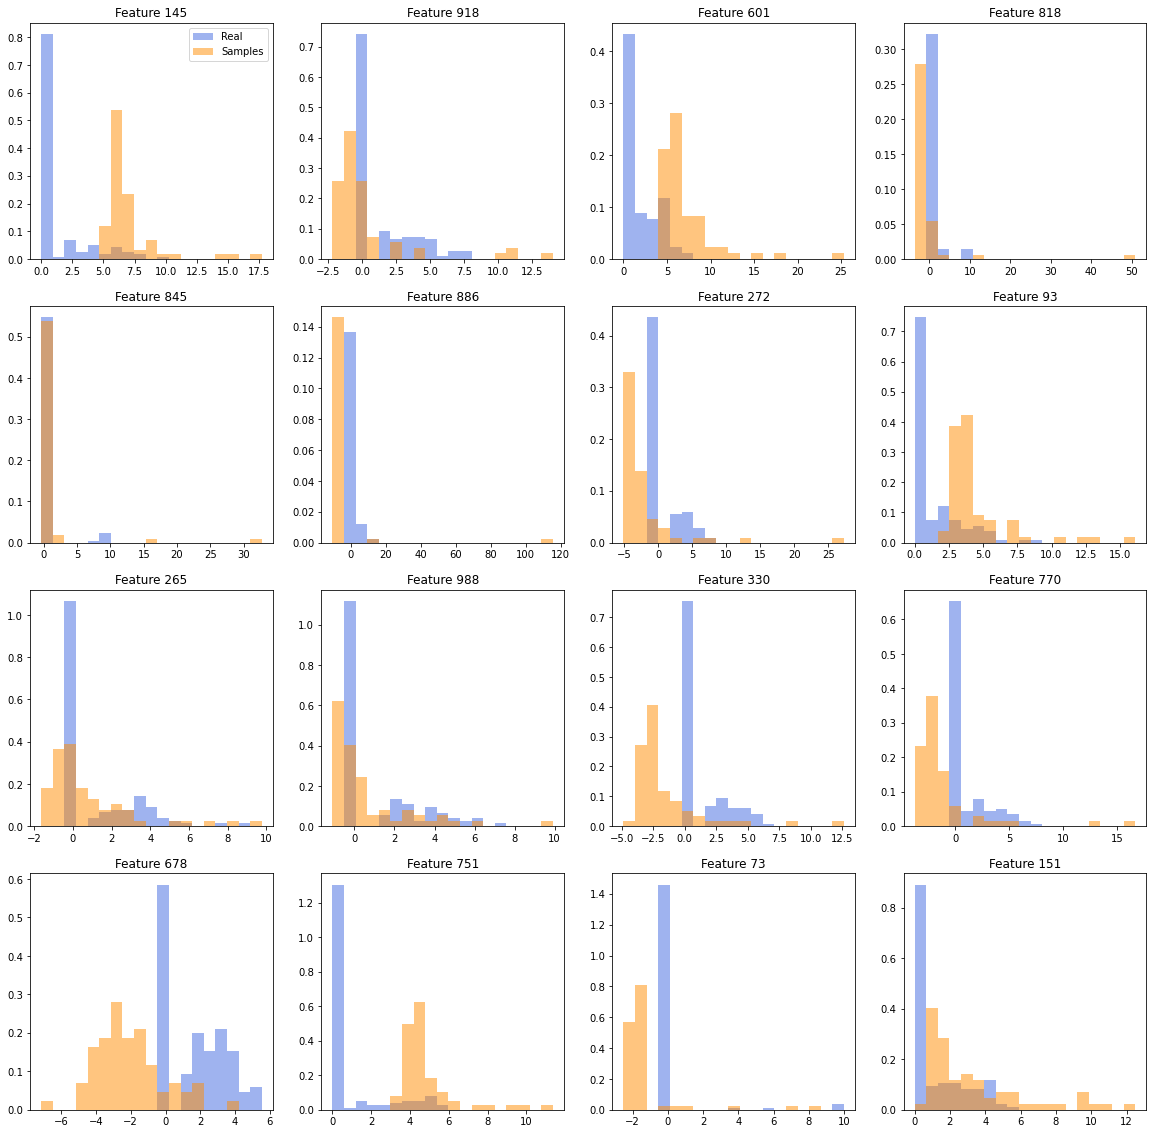

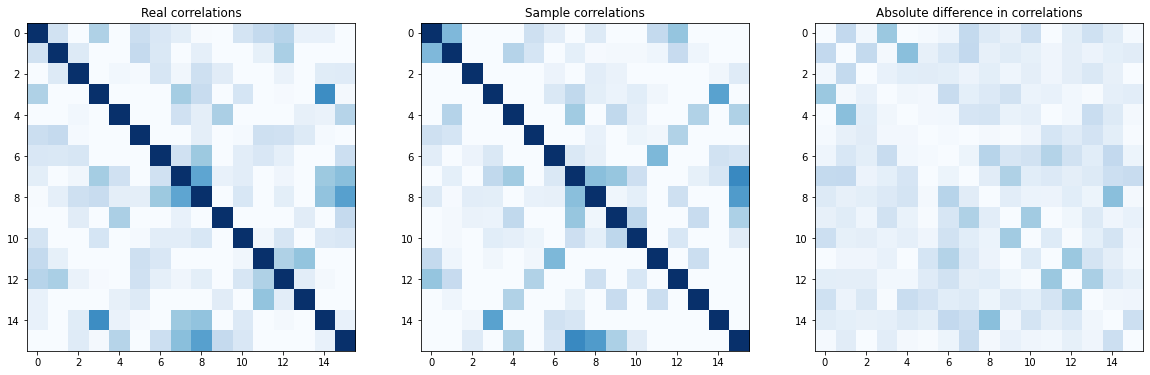

In [11]:
# For simplicity, sample a lot of inputs for the real data
data, targets = [], []
for _ in range(len(classes)):
    x, y = next(iter(data_loader))
    data.append(x.cpu().numpy())
    targets.append(y.cpu().numpy())
data = np.concatenate(data)
targets = np.concatenate(targets)

for class_to_sample in classes:
    print("Class %s" % class_to_sample)
    real = data[targets == class_to_sample]
    sample = samples[class_to_sample]
    
    # Decide which features to plot
    num_features = min(input_shape[0], 16)
    feature_inds = np.flip(np.argsort(np.std(real, axis=0)))[:num_features]
    # feature_inds = np.random.choice(input_shape[0], size=num_features, replace=False)
    
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    # Plot feature values
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, f_i]
        sample_vals = sample[:, f_i]
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    plt.show()

    # Compute and plot correlations
    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i, f_i in enumerate(feature_inds):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            f_j = feature_inds[j]
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, f_i], real[:, f_j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, f_i], sample[:, f_j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()